# Grafice raport CDOS

Acest Jupyter Notebook permite generarea unor grafice pe baza răspunsurilor la chestionarul CDOS.

## Import de biblioteci

In [1]:
from pathlib import Path
import re
from textwrap import fill
import string

import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import rcParams

## Configurare

### Configurare folder de input

Fișierele Excel se vor citi din acest fișier.

In [2]:
input_directory = Path('.')

### Configurare folder de output

Toate graficele generate se vor salva în acest loc.

In [3]:
output_directory = Path('output')

output_directory.mkdir(parents=True, exist_ok=True)

### Configurare stilizare

In [4]:
# Creștem densitatea în pixeli a figurilor generate
rcParams['figure.dpi'] = 96

# TODO: nu-mi dau seama de ce nu merge să schimbăm fontul
# https://fonts.google.com/specimen/IBM+Plex+Sans?query=plex
# rcParams['font.family'] = 'sans-serif'
# rcParams['font.sans-serif'] = ['IBM Plex Sans']

# Set the default style to be used in making graphics
plt.style.use('default')

## Citire date

In [5]:
df = pd.read_excel(input_directory / 'CDOS Licență (Responses).xlsx', engine='openpyxl')

## Definire funcții de prelucrare date

In [6]:
# Acest regex e folosit ca să elimine sufixul numeric
# adăugat automat de `pandas` pe coloanele cu nume duplicat.
#
# Ex. dacă coloana inițială se numea "test", puteam avea
# o coloană duplicată redenumită la "test.13".
remove_column_suffix_regex = re.compile(r'\.[0-9]+$')

def convert_column_name_to_question(column):
    """Transformă numele unei coloane într-o întrebare,
    așa cum apărea ea inițial în formular.
    """
    return remove_column_suffix_regex.sub('', column)

## Generare grafice

### Funcții comune

In [7]:
def plot_question_title(ax: plt.Axes, answers: pd.Series) -> None:
    "Afișează întrebarea adresată respondenților ca titlul graficului."
    question = convert_column_name_to_question(answers.name)
    title = fill(question, 60)
    ax.set_title(title)

def plot_number_of_respondents(ax: plt.Axes, answers: pd.Series) -> None:
    "Afișează numărul de respondenți la o întrebare în partea de jos a graficului."
    ax.text(0, -1.3,
            f'{answers.count()} respondenți',
            ha='center', va='center')
    
def col2index(col):
    """Convertește numele coloanei din Excel în indexul corespunzător."""
    num = 0
    for c in col:
        if c in string.ascii_letters:
            num = num * 26 + (ord(c.upper()) - ord('A')) + 1
    return num - 1

### Întrebări cu da sau nu

In [8]:
NO_ANSWER_VALUE = 'Nu știu / nu răspund'

def plot_yes_no_question(ax: plt.Axes, answers: pd.Series) -> None:
    """Reprezintă grafic răspunsurile la o întrebare de tip da/nu,
    sub formă de pie chart.
    """
    # Înlocuiește răspunsurile goale cu o formulare standard
    answers = answers.fillna(NO_ANSWER_VALUE)
    
    # Calculează vectorul de frecvență al răspunsurilor
    counts = answers.value_counts()
    
    # Sortează tipurile de răspunsuri într-o ordine standard
    counts = counts[['Da', 'Nu', NO_ANSWER_VALUE]]

    plot_question_title(ax, answers)
    plot_number_of_respondents(ax, answers)

    # Afișez vectorul de frecvență ca un pie chart
    counts.plot.pie(
        ax=ax,
        # pandas pune automat numele coloanei pe axa verticală,
        # nu ne dorim asta
        ylabel='',
        colors = ['#b62f8b','#d6556d','#fa9b3b'],
        # TODO: nu se prea vede bine textul generat automat
        autopct='%1.1f%%',
        explode=(0, 0.2, 0.1))

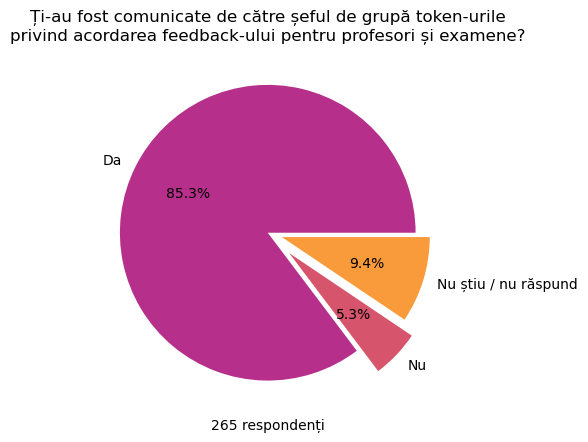

In [9]:
answers = df.iloc[:, -6]

fig = plt.figure()
ax = fig.gca()
plot_yes_no_question(ax, answers)
plt.show()

### Întrebări cu rating de la 1 la 5

In [10]:
def plot_rating_question(ax: plt.Axes, answers: pd.Series) -> None:    
    # Calculează vectorul de frecvență al răspunsurilor
    counts = answers.value_counts()
    
    counts = counts.sort_index()

    plot_question_title(ax, answers)
    # TODO: nu arată bine
    #plot_number_of_respondents(ax, answers)

    counts.plot.bar(ax=ax, color = '#b62f8b')
    
    # Afișează vertical valorile pe axa X
    ax.tick_params(axis='x', rotation=0)

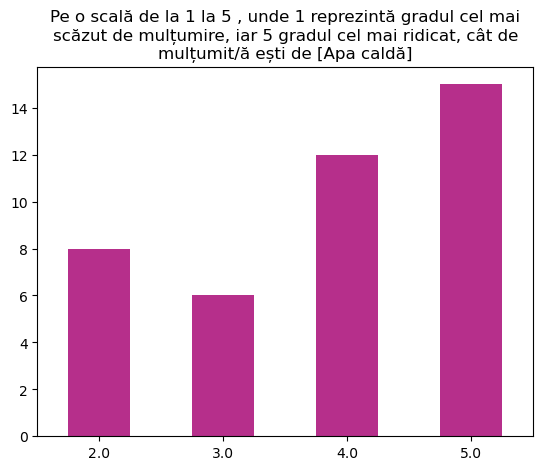

In [11]:
answers = df.iloc[:, 283]

fig = plt.figure()
ax = fig.gca()
plot_rating_question(ax, answers)
plt.show()

### Întrebări cu răspuns multiplu

In [12]:
def plot_multiple_choice_question(ax: plt.Axes, answers: pd.Series) -> None:
    # Ignor răspunsurile goale
    answers = answers.dropna()

    # Dacă nu mai rămâne nimic, continui
    if answers.empty:
        return

    # Sparg coloana cu răspunsurile (un șir de alegeri separate prin virgulă)
    # în mai multe coloane.
    #
    # Bazat pe https://stackoverflow.com/a/46856366/5723188
    separated_answers = answers.str.split(',', expand=True)

    # Determin frecvența cu care apare pe fiecare nouă coloană fiecare răspuns.
    #
    # Bazat pe https://stackoverflow.com/a/32589877/5723188
    counts = separated_answers.apply(pd.Series.value_counts)

    # Determin per total cât de frecvent a apărut fiecare răspuns la această întrebare.
    counts = counts.sum(axis=1)

    # Sortez după numărul de apariții
    counts = counts.sort_values()

    plot_question_title(ax, answers)
    # TODO: nu se poziționează cum trebuie
    #plot_number_of_respondents(ax, answers, 4, -2.5)
    counts.plot.barh(ax=ax, color = '#b62f8b')

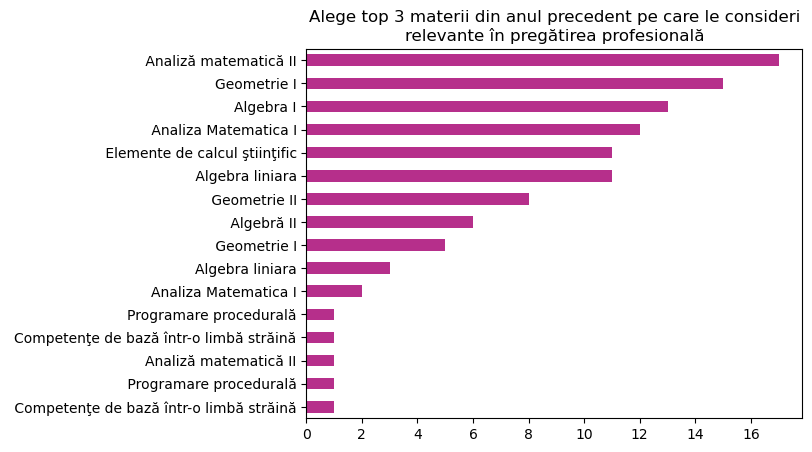

In [13]:
answers = df.iloc[:, 49]

fig = plt.figure()
ax = fig.gca()
plot_multiple_choice_question(ax, answers)
plt.show()

## Întrebări pe specializări

### Mapare indici coloane

Studenții aleg inițial anul și specializarea lor. În funcție de acestea, sunt redirecționați la secțiuni diferite din formular.

Acest bloc de cod definește numărul coloanei de la care încep coloanele corespunzătoare fiecărei specializări.

Link util pentru conversia de la coloană Excel în indice: https://www.vishalon.net/blog/excel-column-letter-to-number-quick-reference

In [14]:
# Dictionary mapping each (year, specialization) pair to a column number in the Excel
offset_map = {
    'I': {
        'Informatică - seria 13': col2index('F'),
        'Informatică - seria 14': col2index('F'),
        'Informatică - seria 15': col2index('F'),
        'Matematică - seria 10': col2index('AX'),
        'Matematică - seria 11': col2index('AX'),
        'Calculatoare și tehnologia informației': col2index('EX'),
    },
    'II': {
        'Informatică - seria 23': col2index('T'),
        'Informatică - seria 24': col2index('T'),
        'Matematici Aplicate': col2index('DU'),
        'Matematică': col2index('BM'),
        'Matematică - Informatică': col2index('CQ'),
        'Calculatoare și Tehnologia Informației': col2index('FL'),
    },
    'III': {
        'Informatică - seria 33': col2index('AH'),
        'Informatică - seria 34': col2index('AH'),
        'Matematici Aplicate': col2index('EI'),
        'Matematică - Informatică': col2index('DE'),
        'Calculatoare și Tehnologia Informației': col2index('FZ'),
    },
    'IV': {
        'Calculatoare și Tehnologia Informației': col2index('GN'),
    }
}

### Generare grafice per an/specializare

In [ ]:
# Trebuie să luăm fiecare an de studiu pe rând
for index, year in enumerate(('I', 'II', 'III', 'IV')):
    # Filtrăm răspunsurile
    df_year = df[df['Anul de studiu în 2020-2021'] == f'Anul {year}'].copy()

    # Determinăm specializarea
    if year == 'IV':
        # Pentru anul 4 nu avem o coloană de "Specializare",
        # pentru că singura posibilitate ar fi fost CTI.
        #
        # Așa că o adăugăm manual.
        specialization_column_name = 'Specializare anul IV'
        df_year[specialization_column_name] = 'Calculatoare și Tehnologia Informației'
    else:
        # Coloana care indică specializarea e diferită în funcție de an
        specialization_column_index = 2 + index
        specialization_column_name = df_year.columns[specialization_column_index]
    
    specialization = df_year[specialization_column_name]
    
    print('Anul', year, f'({len(df_year)} respondenți)')
    
    # Grupăm răspunsurile pe ani după specializare
    for group_name, df_group in df_year.groupby(specialization):
        print('-', group_name)
        offset = offset_map[year][group_name]

        # Determin directorul
        directory_path = output_directory / f'Anul {year}' / group_name
        # Îl creez dacă nu există
        directory_path.mkdir(parents=True, exist_ok=True)

        # Rezolv întrebările de tip selecție multiplă
        for i in list(range(3)) + list(range(4, 8)):
            index = offset + i

            answers = df_group.iloc[:, index]

            # Plotez graficul
            fig = plt.figure()
            ax = fig.gca()
            plot_multiple_choice_question(ax, answers)
            fig.savefig(directory_path / f'{i}.png', bbox_inches='tight')
            plt.close(fig)

Anul I (130 respondenți)
- Calculatoare și tehnologia informației
- Informatică - seria 13
